# Import everything!

In [1]:
import torch
import torchvision


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.animation as animation


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Simple feed foward network

In [9]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.dropout1 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        
        output = F.log_softmax(x, dim=1)
        return output
    
    

class PositiveNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(PositiveNet, self).__init__()
        self.weight = nn.Parameter(torch.randn((in_dim, out_dim)))
        self.bias = nn.Parameter(torch.zeros((out_dim,)))
        
    def forward(self, x):
        return F.log_softmax(torch.matmul(x, torch.abs(self.weight)) + self.bias,dim=1)

## Train and test functionality

In [3]:
def train(model, device, train_loader, optimizer, epoch,log_interval=10,dry_run=False,plot=False,save_weights=False):
    model.train()
    
#     if plot:


    if save_weights:
        # n_weights x training_steps
        
        weights, biases = model.state_dict().items()
        n_weights = weights[1][5].cpu().shape[0]
        n_training_steps = len(train_loader)
        n_classes = 10
        
        weights_out = np.zeros((n_classes,n_weights, n_training_steps))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break
                
        if save_weights:
            weights, biases = model.state_dict().items()
            #Get weights of layer 1 for neuron 5
            
#             weights[1].cpu().numpy()
            
            
            weights_out[...,batch_idx] = weights[1].cpu().numpy()
            
    if save_weights:
        return weights_out
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [4]:
# device = torch.device("cuda")
device = torch.device("cpu")

# Data inputting

In [5]:
batch_size = 64
test_batch_size = 1
lr = .1
gamma = .7
epochs = 1
log_interval = 10000
save_model = True

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [6]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)

dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)


def transf_data_set(dataset):
    new_dataset = []
    for x,y in dataset:
        new_dataset.append((x.flatten(),y))
        
    return new_dataset

d1 = transf_data_set(dataset1)
d2 = transf_data_set(dataset2)



# Train and save data into: weights_data

In [10]:
train_loader = torch.utils.data.DataLoader(d1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(d2, **test_kwargs)

# model = Net().to(device)
model = PositiveNet(784,10).to(device)
num_models = 30

# optimizer = optim.Adadelta(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

weight_data = None

for model_i in range(num_models):
    
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    for epoch in range(1, epochs + 1):
        weights_temp = train(model, device, train_loader, optimizer, epoch, log_interval,save_weights=True)
        test(model, device, test_loader)
#         scheduler.step()
    if model_i == 0:
        weights_data = weights_temp[np.newaxis, ...]
    else:
        weights_data = np.vstack([weights_data, weights_temp[np.newaxis, ...]])



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.733683


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3326, Accuracy: 8997/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.674750


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3316, Accuracy: 9001/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.481333


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3275, Accuracy: 9031/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.505360


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3488, Accuracy: 8962/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.511469


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3363, Accuracy: 8987/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462050


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3423, Accuracy: 8979/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.469722


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3524, Accuracy: 8943/10000 (89%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.432583


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3270, Accuracy: 9046/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.465439


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3346, Accuracy: 9009/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.493422


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3375, Accuracy: 8988/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.681753


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3235, Accuracy: 9049/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.709666


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3361, Accuracy: 8988/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.609236


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3351, Accuracy: 9014/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.678806


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3262, Accuracy: 9048/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.415957


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3257, Accuracy: 9049/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.602167


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3318, Accuracy: 9015/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.575125


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3331, Accuracy: 9015/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.440718


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3371, Accuracy: 9007/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.239779


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3411, Accuracy: 8999/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.465774


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3362, Accuracy: 9008/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.403109


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3331, Accuracy: 9028/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.713173


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3432, Accuracy: 8992/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.454694


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3244, Accuracy: 9062/10000 (91%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.487620


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3343, Accuracy: 9007/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.473086


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3373, Accuracy: 8988/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.481474


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3368, Accuracy: 9022/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.387042


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3264, Accuracy: 9036/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.699319


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3251, Accuracy: 9043/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419246


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3242, Accuracy: 9048/10000 (90%)



[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.472671


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



Test set: Average loss: 0.3365, Accuracy: 9027/10000 (90%)



In [11]:
print(weights_data.shape)

(30, 10, 784, 938)


## Print out what each model's *0* receptive field looks like

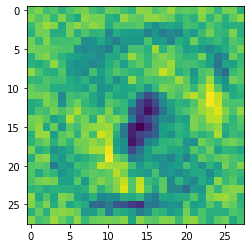

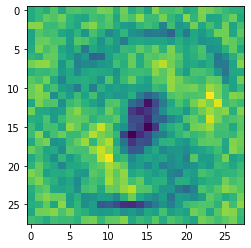

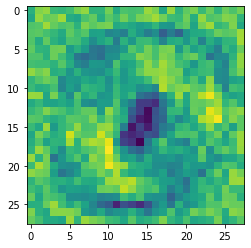

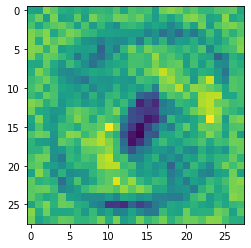

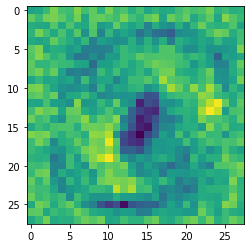

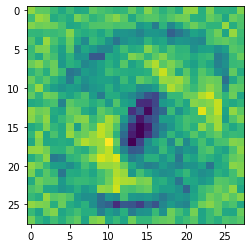

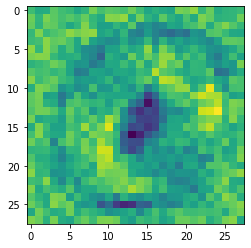

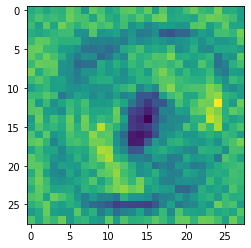

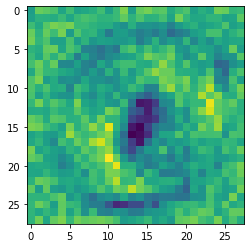

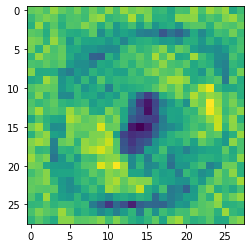

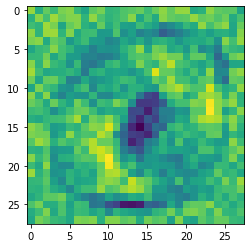

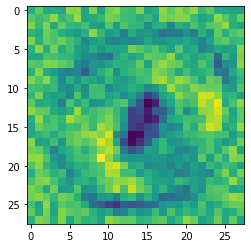

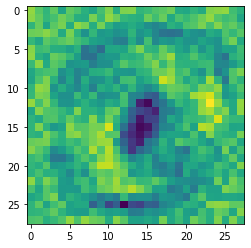

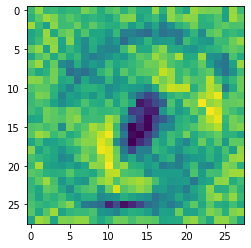

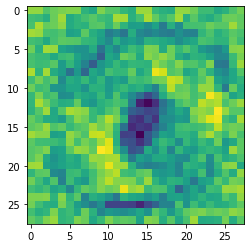

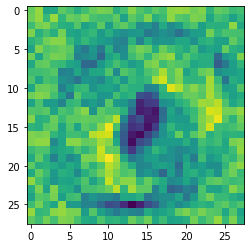

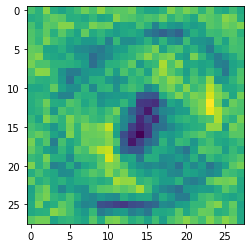

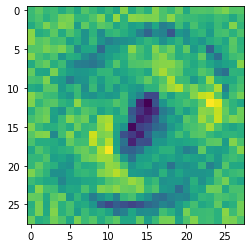

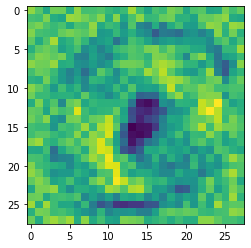

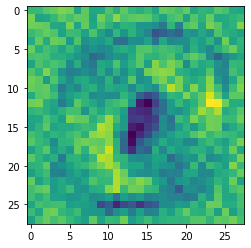

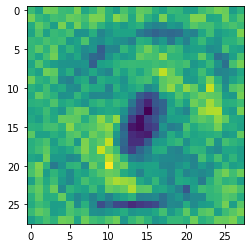

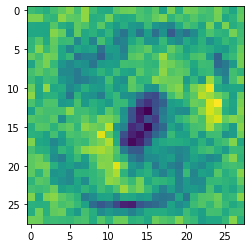

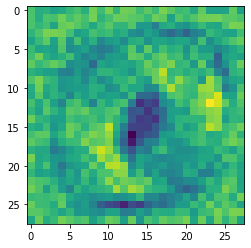

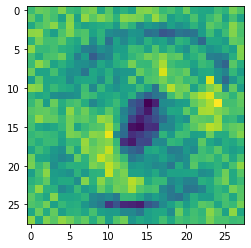

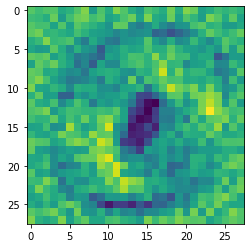

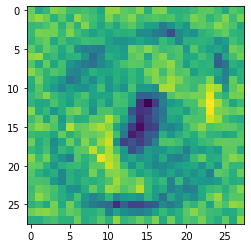

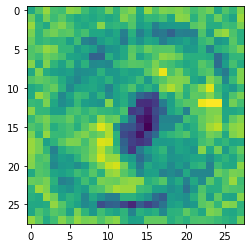

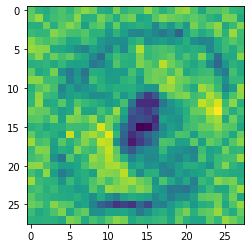

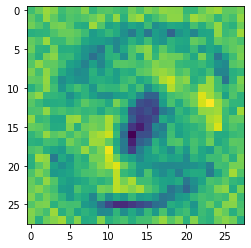

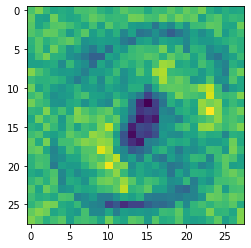

In [12]:

for model_i in range(num_models):
    plt.imshow(weights_data[model_i,0,:,-1].reshape((28,28)))
    plt.show()

# Time for TCA
We will attempt to see learning for each neuron's receptive field through 1 epoch

In [12]:
!pip3 install git+https://github.com/ahwillia/tensortools

'pip3' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
import tensortools as tt

Fitting rank-2 models:   0%|     | 0/2 [00:00<?, ?it/s]

(30, 10, 784, 938)


Rank-2 models:  min obj, 0.95;  max obj, 0.95;  time to fit, 52.0s


Rank-3 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 77.2s


Rank-4 models:  min obj, 0.92;  max obj, 0.94;  time to fit, 93.1s


Rank-5 models:  min obj, 0.91;  max obj, 0.92;  time to fit, 72.2s


Rank-6 models:  min obj, 0.89;  max obj, 0.90;  time to fit, 104.9s


Rank-7 models:  min obj, 0.88;  max obj, 0.90;  time to fit, 95.0s


Rank-8 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 82.7s


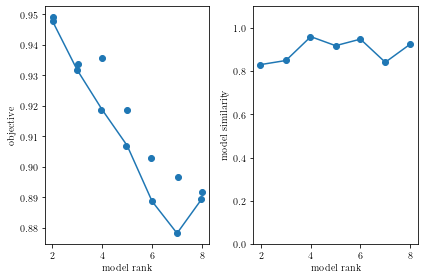

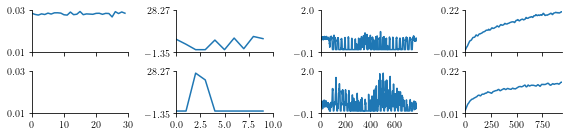

In [26]:
data = weights_data #numpy array of neural weights
print(data.shape)

# Fit an ensemble of models
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(data, ranks=range(2, 9), replicates=2)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 2
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

# Visualize 3 components

<IPython.core.display.Javascript object>


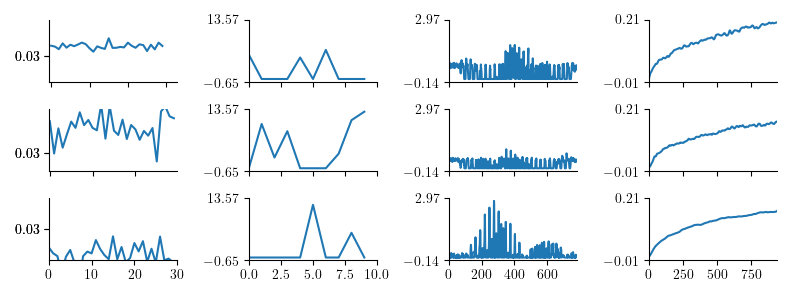

C:\Users\Ash\Anaconda3\envs\bgr\lib\site-packages\tensortools\visualization.py:232: UserWarning: Attempting to set identical bottom == top == 0.03 results in singular transformations; automatically expanding.
  axes[r, i].set_ylim((ymin, ymax))


In [84]:
num_components = 3
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

# Visualize the weight factors

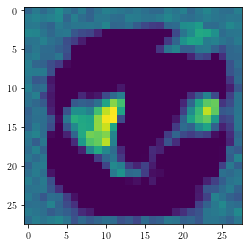

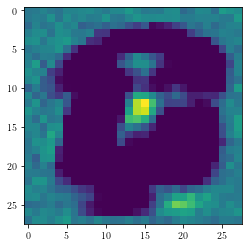

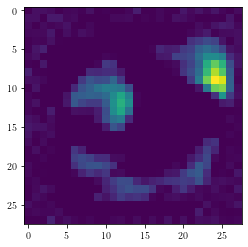

In [44]:

facts = ensemble.factors(num_components)[replicate]

for rep in ensemble.factors(num_components)[replicate][2].T:
    plt.imshow(rep.reshape(28,28))
    plt.show()

# Plot any factor as a bar chart:

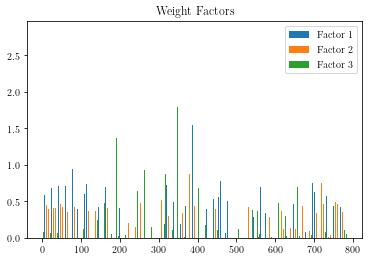

In [105]:
def bar_fact(fact,title=''):
    
    fig,ax = plt.subplots(1,1)#,figsize=(10,2))
    n_ind = np.arange(fact.shape[0])
    width = 0.2

    for lat_ind in range(fact.shape[1]):

        plt.bar(n_ind + lat_ind*width, fact[:,lat_ind],width,label="Comp:{}".format(lat_ind))
    # ax.set_xticks(np.arange(0,facts[0].shape[0]))
    plt.title(title)
    # ax.set_xlabel("Neuron #")
    plt.legend(['Factor 1','Factor 2','Factor 3'])
    
bar_fact(facts[2],'Weight Factors')

# Plot any factor as a line chart

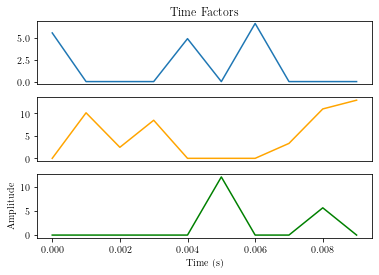

In [99]:
def line_fact(fact):

    ax = plt.subplot(3, 1, 1, title="Time Factors")
    ax.plot(fact[:,0])
    ax.set_xticks([])

    ax1 = plt.subplot(3, 1, 2, title="")
    ax1.plot(fact[:,1],c='orange')
    ax1.set_xticks([])

    ax2 = plt.subplot(3, 1, 3, title="")
    ax2.plot(np.arange(fact[:,2].shape[0])/1000,fact[:,2],c='green')

    ax2.set_xlabel
    # plt.legend(['F1','F2','F3'])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

line_fact(facts[1])

# line_fact(facts[3])


## Factors are stored in the ensemble list, as: (dim, reduced dim)

In [60]:

facts = ensemble.factors(3)[0]
print(facts[1].shape)


(10, 3)


# Reduce the dimension by the weight factor, factor 2

In [75]:
q = []
for i in range(data.shape[1]):
    q.append(np.stack([np.matmul(b.T, facts[2]).T for b in data[:,i,...]],axis=0))
q = np.array(q)
print(q.shape)

(10, 30, 3, 938)


# Plot in 2D for fun

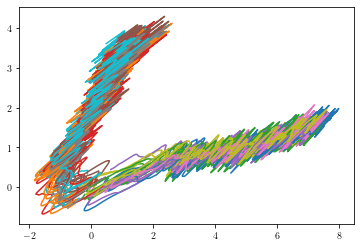

In [71]:
%matplotlib inline
for i in range(num_models):
    plt.plot(c[i,0,:],c[i,1,:])
    plt.plot(d[i,0,:],d[i,1,:])

# Plot in 3D and see seperable trajectories

In [65]:
from mpl_toolkits.mplot3d import Axes3D
data.shape

<IPython.core.display.Javascript object>


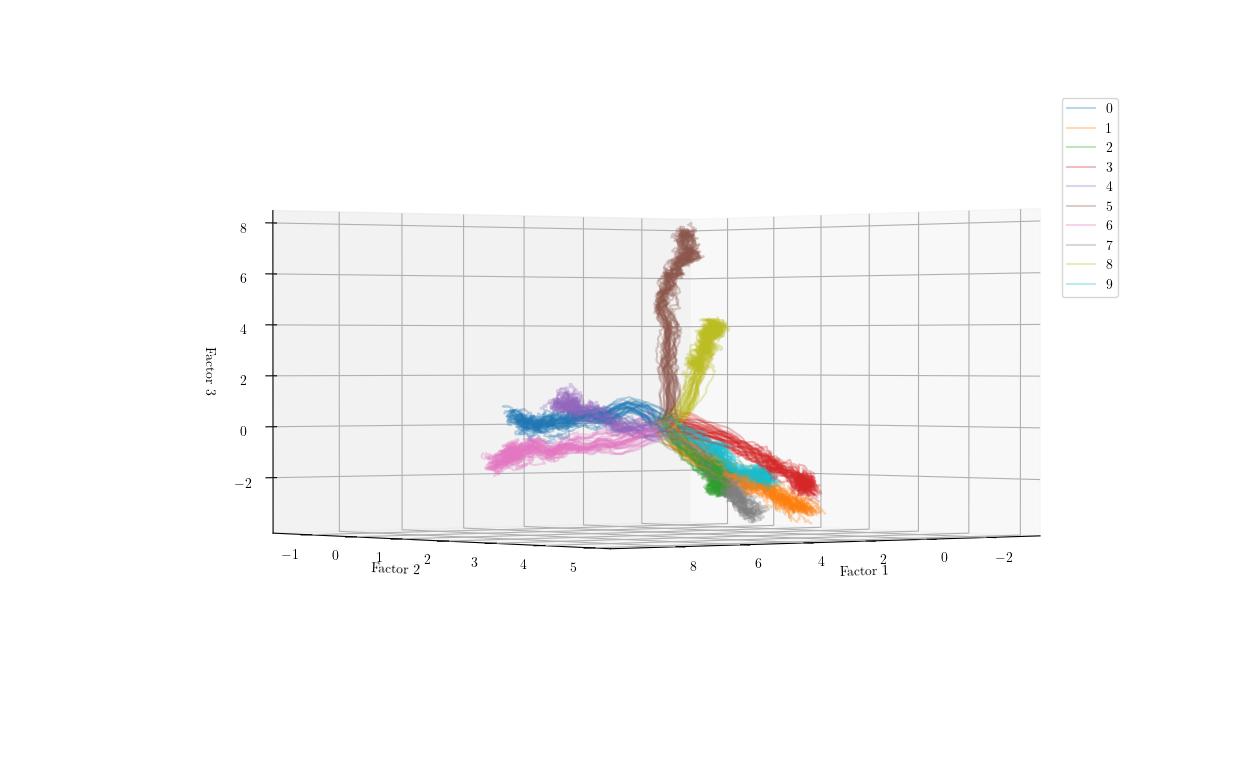

In [106]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(num_models):
    for j in range(10):
        plt.plot(q[j,i,0,:],q[j,i,1,:],q[j,i,2,:],alpha=.3)

plt.legend(['{}'.format(i) for i in range(10)])
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
plt.show()
#         plt.plot(d[i,0,:],d[i,1,:],d[i,2,:],'r',alpha=.3)

# Attempt to make animations